In [2]:
# Remote Sensing Classification with Relation Networks - OPTIMIZED VERSION
# For NPWU, EURO, and AID Datasets in Google Colab

import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
from google.colab import drive
import zipfile
import warnings

from PIL import ImageFile
from torch.cuda.amp import autocast, GradScaler

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='PIL.TiffImagePlugin')

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
# Add rasterio for handling multi-band images
try:
    import rasterio
    from rasterio.plot import reshape_as_image
except ImportError:
    print("Installing required packages...")
    !pip install rasterio

    # Retry import after installation
    import rasterio
    from rasterio.plot import reshape_as_image

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.4 MB/s eta 0:00:00


In [4]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the data path - adjust this to your actual path in Google Drive
DATA_PATH = "/content/drive/MyDrive/datasets"
os.makedirs(DATA_PATH, exist_ok=True)

# Extract zip files if needed
def extract_datasets():
    """Extract dataset zip files if they don't already exist"""
    datasets = ['NPWU', 'EURO', 'AID']
    ZIP_PATH = "/content/drive/MyDrive/datasets"

    for dataset in datasets:
        # Check if dataset is already extracted
        dataset_dir = os.path.join(DATA_PATH, dataset)
        if os.path.exists(dataset_dir):
            print(f"{dataset} dataset already extracted at {dataset_dir}")
            continue

        # Look for zip file
        zip_file = None
        possible_names = [
            f"{dataset}.zip",
            f"{dataset.lower()}.zip",
            f"{dataset}_dataset.zip",
            f"{dataset.lower()}_dataset.zip"
        ]
        for name in possible_names:
            potential_path = os.path.join(ZIP_PATH, name)
            if os.path.exists(potential_path):
                zip_file = potential_path
                break

        if zip_file is None:
            print(f"Could not find zip file for {dataset} dataset.")
            continue

        # Extract the zip file
        print(f"Extracting {zip_file} to {DATA_PATH}...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(DATA_PATH)

        # Check if extraction was successful
        if os.path.exists(dataset_dir):
            print(f"Successfully extracted {dataset} dataset")
        else:
            print(f"Note: Extraction complete, but did not find expected directory '{dataset}'")

# Create a timestamp for saving results
TIMESTAMP = time.strftime("%Y%m%d-%H%M%S")


Mounted at /content/drive


In [5]:
# Create directory for saving results
RESULTS_DIR = f"/content/drive/MyDrive/relation_network_results_{TIMESTAMP}"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [6]:
# Check for GPU
GPU = 0 if torch.cuda.is_available() else -1
device = torch.device(f"cuda:{GPU}" if GPU >= 0 else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [7]:
# Hyperparameters - OPTIMIZED
FEATURE_DIM = 64          # Feature dimension in CNN encoder
RELATION_DIM = 8          # Hidden layer size in relation network
CLASS_NUM = 5             # Number of classes in few-shot tasks (N-way)
SAMPLE_NUM_PER_CLASS = 1  # Number of samples per class (K-shot)
BATCH_NUM_PER_CLASS = 15  # Number of query images per class
EPISODE = 50              # REDUCED: Number of episodes/tasks
TEST_EPISODE = 10         # REDUCED: Number of test episodes/tasks
LEARNING_RATE = 0.001     # Learning rate
IMG_SIZE = 64             # REDUCED: Input image size (from 84 to 64)
BATCH_SIZE = 256          # INCREASED: Batch size for data loading
DATA_SUBSET = 0.3         # Use only 30% of data for faster training
NUM_WORKERS = 8           # Increased workers for faster data loading



In [8]:
# Network Models - Simplified for smaller images
class CNNEncoder(nn.Module):
    """CNN Encoder for feature extraction - Optimized for smaller images"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out  # 64x14x14 output for 64x64 input


In [9]:
class RelationNetwork(nn.Module):
    """Relation Network to compare query and support set - Optimized"""
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.BatchNorm2d(64, momentum=1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Adjusted for smaller feature maps due to smaller input images
        self.fc1 = nn.Linear(input_size*2*2, hidden_size)  # Adjusted for 64x64 input
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out



In [10]:
class RemoteSensingDataset(Dataset):
    """Dataset class for remote sensing images"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



In [11]:
def load_dataset(dataset_name, data_path):
    """Load images and labels from dataset folder with improved error handling - Fixed for multi-band TIFF"""
    dataset_dir = os.path.join(data_path, dataset_name)

    # Check if dataset exists
    if not os.path.exists(dataset_dir):
        print(f"Dataset directory {dataset_dir} not found.")
        return [], [], []

    images = []
    labels = []
    error_count = 0
    tiff_count = 0

    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_dir)
                     if os.path.isdir(os.path.join(dataset_dir, f))]
    class_names = sorted(class_folders)

    print(f"Loading {dataset_name} dataset with {len(class_names)} classes")

    # For each class, load all images
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_dir, class_name)

        # Get all image files in this class folder
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]

        print(f"  Processing class '{class_name}' with {len(image_files)} images...")

        # OPTIMIZATION: Random subset for faster loading
        if DATA_SUBSET < 1.0:
            sample_size = int(len(image_files) * DATA_SUBSET)
            image_files = random.sample(image_files, min(sample_size, len(image_files)))
            print(f"  Using subset of {len(image_files)} images")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)

            try:
                # Check file extension to determine how to load it
                if img_file.lower().endswith(('.tif', '.tiff')):
                    tiff_count += 1
                    # Use rasterio directly for all TIFF files - more reliable for remote sensing data
                    with rasterio.open(img_path) as src:
                        # Get the number of bands
                        band_count = src.count

                        if band_count >= 3:
                            # If we have 3+ bands, use the first three (RGB typically)
                            img_array = src.read([1, 2, 3])
                        elif band_count == 2:
                            # For 2 bands, duplicate the second band for the third
                            img_array = np.vstack([src.read(), src.read(2)[np.newaxis, :, :]])
                        else:
                            # For single band, create RGB by duplicating
                            band = src.read(1)
                            img_array = np.stack([band, band, band], axis=0)

                        # Convert to image format (H,W,C)
                        img_array = reshape_as_image(img_array)

                        # Normalize to 0-255 range if needed
                        if img_array.dtype != np.uint8:
                            img_array = np.clip(img_array, 0, None)  # Ensure no negative values
                            if img_array.max() > 0:  # Avoid division by zero
                                img_array = (img_array / img_array.max() * 255).astype(np.uint8)
                            else:
                                img_array = np.zeros_like(img_array, dtype=np.uint8)

                        # Convert to PIL Image
                        img = Image.fromarray(img_array[:, :, :3], 'RGB')  # Ensure only 3 channels
                else:
                    # Regular image files - use PIL directly
                    img = Image.open(img_path).convert('RGB')

                # Add to dataset
                images.append(img)
                labels.append(class_idx)

            except Exception as e:
                error_count += 1
                if error_count <= 5:  # Limit error output
                    print(f"    Error loading image {img_file}: {str(e)}")
                elif error_count == 6:
                    print("    Additional errors omitted...")

    print(f"Successfully loaded {len(images)} images from {dataset_name}")
    print(f"TIFF images processed: {tiff_count}")
    if error_count > 0:
        print(f"Total errors encountered: {error_count}")

    return images, labels, class_names

In [12]:
def preprocess_dataset(dataset_name, data_path):
    """Load and preprocess dataset - Optimized"""
    # Load the dataset
    images, labels, class_names = load_dataset(dataset_name, data_path)

    if len(images) == 0:
        return None, None, None, []

    # Define transformations - OPTIMIZED for smaller images
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Add color jittering for better generalization
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Split the dataset
    train_indices, temp_indices = train_test_split(
        list(range(len(images))), test_size=0.3, random_state=SEED,
        stratify=labels
    )
    val_indices, test_indices = train_test_split(
        temp_indices, test_size=0.5, random_state=SEED,
        stratify=[labels[i] for i in temp_indices]
    )

    # Create datasets
    try:
        # Create train dataset
        train_images = [images[i] for i in train_indices]
        train_labels = [labels[i] for i in train_indices]
        train_dataset = RemoteSensingDataset(train_images, train_labels, transform=train_transform)

        # Create validation dataset (smaller subset)
        val_images = [images[i] for i in val_indices]
        val_labels = [labels[i] for i in val_indices]
        val_dataset = RemoteSensingDataset(val_images, val_labels, transform=test_transform)

        # Create test dataset (smaller subset)
        test_images = [images[i] for i in test_indices]
        test_labels = [labels[i] for i in test_indices]
        test_dataset = RemoteSensingDataset(test_images, test_labels, transform=test_transform)

    except Exception as e:
        print(f"Error creating datasets: {str(e)}")
        raise

 # OPTIMIZATION: Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,  # Pin memory for faster data transfer to GPU
        prefetch_factor=2  # Prefetch batches for better throughput
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    return train_loader, val_loader, test_loader, class_names


In [13]:
def create_episode(dataset_loader, n_way, k_shot, n_query):
    """Create a few-shot learning episode/task - Optimized version"""
    # Get all data from dataloader - more efficient approach
    data_all = []
    label_all = []

    # OPTIMIZATION: Limit number of batches to process for speed
    max_batches = 10
    for i, (data, label) in enumerate(dataset_loader):
        if i >= max_batches:  # Limit data loading to save time
            break
        data_all.append(data)
        label_all.append(label)

    if not data_all:  # Check if we loaded any data
        raise ValueError("No data loaded from data loader")

    data_all = torch.cat(data_all, dim=0)
    label_all = torch.cat(label_all, dim=0)

    # Get unique labels
    unique_labels = torch.unique(label_all)

    # Check if we have enough classes
    if len(unique_labels) < n_way:
        print(f"Warning: Only {len(unique_labels)} classes available, but requested {n_way}")
        n_way = min(n_way, len(unique_labels))

    # Randomly select n_way classes
    selected_classes = torch.tensor(random.sample(unique_labels.tolist(), n_way))
    support_images = []
    support_labels = []
    query_images = []
    query_labels = []

    # For each selected class
    for i, cls in enumerate(selected_classes):
        # Find all samples of this class
        idx = torch.nonzero(label_all == cls).squeeze()

        # Handle single-element tensors
        if idx.dim() == 0:
            idx = idx.unsqueeze(0)

        # Check if we have enough samples
        if len(idx) < k_shot + n_query:
            print(f"Warning: Class {cls} has only {len(idx)} samples, but need {k_shot + n_query}")
            # Use available samples with a minimum of 1 for support
            available = len(idx)
            k_available = min(k_shot, max(1, available // 2))
            q_available = available - k_available
    # Randomly select available samples
            perm = torch.randperm(available)
            support_idx = idx[perm[:k_available]]
            query_idx = idx[perm[k_available:k_available+q_available]] if q_available > 0 else support_idx
        else:
            # Randomly select k_shot + n_query samples
            perm = torch.randperm(len(idx))
            support_idx = idx[perm[:k_shot]]
            query_idx = idx[perm[k_shot:k_shot+n_query]]

        # Add support samples
        support_images.append(data_all[support_idx])
        support_labels.append(torch.full((len(support_idx),), i))

        # Add query samples
        query_images.append(data_all[query_idx])
        query_labels.append(torch.full((len(query_idx),), i))

    # Concatenate all support and query samples
    support_images = torch.cat(support_images, dim=0)
    support_labels = torch.cat(support_labels, dim=0)
    query_images = torch.cat(query_images, dim=0)
    query_labels = torch.cat(query_labels, dim=0)

    # Random permutation
    support_perm = torch.randperm(len(support_images))
    support_images = support_images[support_perm]
    support_labels = support_labels[support_perm]
    query_perm = torch.randperm(len(query_images))
    query_images = query_images[query_perm]
    query_labels = query_labels[query_perm]

    return support_images, support_labels, query_images, query_labels


In [14]:
def train_relation_network(dataset_name, train_loader, val_loader, test_loader, n_way=5, k_shot=1):
    """Train and evaluate the relation network - HIGHLY optimized version"""
    # Create a directory for this specific experiment
    exp_name = f"{dataset_name}{n_way}way{k_shot}shot"
    exp_dir = os.path.join(RESULTS_DIR, exp_name)
    os.makedirs(exp_dir, exist_ok=True)

    print(f"Fast Training {n_way}-way {k_shot}-shot learning on {dataset_name}")

    # Initialize models
    feature_encoder = CNNEncoder().to(device)
    relation_network = RelationNetwork(FEATURE_DIM, RELATION_DIM).to(device)

    # Setup optimizers
    feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(), lr=LEARNING_RATE)
    relation_network_optim = torch.optim.Adam(relation_network.parameters(), lr=LEARNING_RATE)

    # Loss function
    mse = nn.MSELoss().to(device)

    # OPTIMIZATION: Set up mixed precision training
    scaler = GradScaler()
    use_amp = torch.cuda.is_available()  # Use automatic mixed precision if on GPU

    # Training history
    train_losses = []
    print(f"Starting quick training for {exp_name}...")
    # Main training loop
    for episode in range(EPISODE):
        start_time = time.time()

        # Train mode
        feature_encoder.train()
        relation_network.train()

        # Create an episode
        try:
            support_images, support_labels, query_images, query_labels = create_episode(train_loader, n_way, k_shot, BATCH_NUM_PER_CLASS)
        except Exception as e:
            print(f"Error creating episode: {e}")
            print("Skipping this episode")
            continue

        # Move to device
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        # OPTIMIZATION: Mixed precision training
        with autocast(enabled=use_amp):
            # Calculate features
            support_features = feature_encoder(support_images)
            query_features = feature_encoder(query_images)
            support_features = feature_encoder(support_images)
            query_features = feature_encoder(query_images)

            # Calculate relations
            n_support = support_features.size(0)
            n_query = query_features.size(0)

            # Expand support and query features for comparison
            support_features_ext = support_features.unsqueeze(0).repeat(n_query, 1, 1, 1, 1)
            query_features_ext = query_features.unsqueeze(1).repeat(1, n_support, 1, 1, 1)

            # Combine support and query features
            relation_pairs = torch.cat((support_features_ext, query_features_ext), dim=2)
            relation_pairs = relation_pairs.view(-1, FEATURE_DIM*2, support_features.size(2), support_features.size(3))

            # Calculate relation scores
            relations = relation_network(relation_pairs)
            relations = relations.view(-1, n_support)

            # Create one-hot labels
            one_hot_labels = torch.zeros(n_query, n_way).to(device)
            one_hot_labels = one_hot_labels.scatter_(1, query_labels.view(-1, 1), 1)

            # Reshape relations to match one-hot labels
            relations_reshaped = torch.zeros(n_query, n_way).to(device)
            for i in range(n_query):
                for j in range(n_support):
                    relations_reshaped[i, support_labels[j]] += relations[i, j]
                relations_reshaped[i] /= k_shot  # Normalize by k_shot

            # Calculate loss
            loss = mse(relations_reshaped, one_hot_labels)
        # Backpropagation with mixed precision
        feature_encoder_optim.zero_grad()
        relation_network_optim.zero_grad()

        # OPTIMIZATION: Use mixed precision for backprop
        scaler.scale(loss).backward()

        # Update with gradient scaling
        scaler.step(feature_encoder_optim)
        scaler.step(relation_network_optim)

        # Update the scale for next iteration
        scaler.update()

        train_losses.append(loss.item())

        # Show results every 5 episodes
        if (episode+1) % 5 == 0:
            end_time = time.time()
            episode_time = end_time - start_time
            print(f"Episode {episode+1}/{EPISODE}, Loss: {loss.item():.4f}, Time: {episode_time:.2f}s")

    # Save final model
    model_path = os.path.join(exp_dir, f"final_model.pt")
    torch.save({
        'feature_encoder': feature_encoder.state_dict(),
        'relation_network': relation_network.state_dict(),
        'episode': EPISODE,
        'n_way': n_way,
        'k_shot': k_shot
    }, model_path)
    # Evaluate on test data with reduced episodes
    test_accuracy = evaluate_relation_network(feature_encoder, relation_network, test_loader, num_episodes=TEST_EPISODE, n_way=n_way, k_shot=k_shot)

    print(f"\nFinal results for {exp_name}:")
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses)
    plt.title(f"{exp_name} Training Loss")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig(os.path.join(exp_dir, f"training_loss.png"))

    # Save results
    results = {
        'dataset': dataset_name,
        'n_way': n_way,
        'k_shot': k_shot,
        'train_losses': train_losses,
        'test_accuracy': test_accuracy
    }

    np.save(os.path.join(exp_dir, f"results.npy"), results)

    return test_accuracy


In [15]:
def evaluate_relation_network(feature_encoder, relation_network, data_loader, num_episodes=10, n_way=5, k_shot=1):
    """Evaluate the relation network - Optimized version"""
    # Set models to evaluation mode
    feature_encoder.eval()
    relation_network.eval()

    total_accuracy = 0.0

    print(f"Evaluating with {num_episodes} episodes...")

    for episode in range(num_episodes):
        # Create an episode
        try:
            support_images, support_labels, query_images, query_labels = create_episode(data_loader, n_way, k_shot, BATCH_NUM_PER_CLASS)
        except Exception as e:
            print(f"Error during evaluation episode {episode}: {e}")
            continue

        # Move to device
        support_images = support_images.to(device)
        query_images = query_images.to(device)
        query_labels = query_labels.to(device)

        # Calculate features
        with torch.no_grad():
            # OPTIMIZATION: Use mixed precision for inference too
            with autocast(enabled=torch.cuda.is_available()):
                support_features = feature_encoder(support_images)
                query_features = feature_encoder(query_images)
                # Calculate relations
                n_support = support_features.size(0)
                n_query = query_features.size(0)

                support_features_ext = support_features.unsqueeze(0).repeat(n_query, 1, 1, 1, 1)
                query_features_ext = query_features.unsqueeze(1).repeat(1, n_support, 1, 1, 1)

                relation_pairs = torch.cat((support_features_ext, query_features_ext), dim=2)
                relation_pairs = relation_pairs.view(-1, FEATURE_DIM*2, support_features.size(2), support_features.size(3))

                relations = relation_network(relation_pairs)
                relations = relations.view(-1, n_support)

                # Create prediction scores
                pred_scores = torch.zeros(n_query, n_way).to(device)
                for i in range(n_query):
                    for j in range(n_support):
                        pred_scores[i, support_labels[j]] += relations[i, j]

                # Get predictions
                _, predictions = torch.max(pred_scores, dim=1)

                # Calculate accuracy
                correct = torch.eq(predictions, query_labels).sum().item()
                accuracy = correct / n_query

                total_accuracy += accuracy

    # Calculate average accuracy across all valid episodes
    avg_accuracy = total_accuracy / num_episodes if num_episodes > 0 else 0
    return avg_accuracy

In [16]:
# Add a new function for the extended comparison plot
def create_comparison_plot_extended(results, datasets, save_path):
    """Create an extended comparison plot across all datasets and all shot configurations"""
    plt.figure(figsize=(14, 8))

    x = np.arange(len(datasets))
    bar_width = 0.15  # Narrower bars to fit all 5 configurations

    # Get accuracies for all shot configurations
    one_shot_accs = [results['1_shot'].get(dataset, {}).get('test_acc', 0) for dataset in datasets]
    two_shot_accs = [results['2_shot'].get(dataset, {}).get('test_acc', 0) for dataset in datasets]
    three_shot_accs = [results['3_shot'].get(dataset, {}).get('test_acc', 0) for dataset in datasets]
    four_shot_accs = [results['4_shot'].get(dataset, {}).get('test_acc', 0) for dataset in datasets]
    five_shot_accs = [results['5_shot'].get(dataset, {}).get('test_acc', 0) for dataset in datasets]

    # Plot bars for all shot configurations
    plt.bar(x - 2*bar_width, one_shot_accs, bar_width, label='1-shot', color='skyblue')
    plt.bar(x - bar_width, two_shot_accs, bar_width, label='2-shot', color='lightgreen')
    plt.bar(x, three_shot_accs, bar_width, label='3-shot', color='orange')
    plt.bar(x + bar_width, four_shot_accs, bar_width, label='4-shot', color='purple')
    plt.bar(x + 2*bar_width, five_shot_accs, bar_width, label='5-shot', color='salmon')

    # Add small accuracy labels on bars (omitted for cleaner look)
    # for i, v in enumerate(one_shot_accs):
    #     plt.text(i - 2*bar_width, v + 0.02, f'{v:.2f}', ha='center', fontsize=8, rotation=90)

    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Few-Shot Learning Performance Comparison', fontsize=14)
    plt.xticks(x, datasets, fontsize=11)
    plt.ylim(0, 1.0)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Extended comparison plot saved to {save_path}")

NPWU dataset already extracted at /content/drive/MyDrive/datasets/NPWU
EURO dataset already extracted at /content/drive/MyDrive/datasets/EURO
AID dataset already extracted at /content/drive/MyDrive/datasets/AID
STARTING FAST RELATION NETWORK TRAINING
Device: cpu
Image size: 64x64
Episodes: 50
Data subset: 30%
Batch size: 256

PROCESSING NPWU DATASET
Loading NPWU dataset with 45 classes
  Processing class 'airplane' with 600 images...
  Using subset of 180 images
  Processing class 'airport' with 600 images...
  Using subset of 180 images
  Processing class 'baseball_diamond' with 600 images...
  Using subset of 180 images
  Processing class 'basketball_court' with 600 images...
  Using subset of 180 images
  Processing class 'beach' with 600 images...
  Using subset of 180 images
  Processing class 'bridge' with 600 images...
  Using subset of 180 images
  Processing class 'chaparral' with 600 images...
  Using subset of 180 images
  Processing class 'church' with 600 images...
  Using

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-14-4cd190ac0a81>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-14-4cd190ac0a81>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enable

Episode 5/50, Loss: 0.1754, Time: 13.08s
Episode 10/50, Loss: 0.1597, Time: 12.92s
Episode 15/50, Loss: 0.1529, Time: 12.49s
Episode 20/50, Loss: 0.1491, Time: 10.84s
Episode 25/50, Loss: 0.1535, Time: 12.23s
Episode 30/50, Loss: 0.1471, Time: 11.43s
Episode 35/50, Loss: 0.1336, Time: 12.42s
Episode 40/50, Loss: 0.1459, Time: 13.38s
Episode 45/50, Loss: 0.1550, Time: 13.59s
Episode 50/50, Loss: 0.1638, Time: 12.23s
Evaluating with 10 episodes...


<ipython-input-15-8e8143015481>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):



Final results for NPWU5way1shot:
Test accuracy: 0.3747

--------------------
5-WAY 2-SHOT ON NPWU
--------------------
Fast Training 5-way 2-shot learning on NPWU
Starting quick training for NPWU5way2shot...
Episode 5/50, Loss: 0.1671, Time: 14.34s
Episode 10/50, Loss: 0.1581, Time: 14.01s
Episode 15/50, Loss: 0.1569, Time: 13.72s
Episode 20/50, Loss: 0.1549, Time: 11.48s
Episode 25/50, Loss: 0.1476, Time: 14.11s
Episode 30/50, Loss: 0.1465, Time: 12.79s
Episode 35/50, Loss: 0.1654, Time: 12.20s
Episode 40/50, Loss: 0.1560, Time: 14.12s
Episode 45/50, Loss: 0.1560, Time: 13.38s
Episode 50/50, Loss: 0.1381, Time: 11.47s
Evaluating with 10 episodes...

Final results for NPWU5way2shot:
Test accuracy: 0.4227

--------------------
5-WAY 3-SHOT ON NPWU
--------------------
Fast Training 5-way 3-shot learning on NPWU
Starting quick training for NPWU5way3shot...
Episode 5/50, Loss: 0.1896, Time: 15.00s
Episode 10/50, Loss: 0.1623, Time: 14.07s
Episode 15/50, Loss: 0.1597, Time: 13.98s
Episode

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-14-4cd190ac0a81>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-14-4cd190ac0a81>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enable

Episode 5/50, Loss: 0.1880, Time: 8.95s
Episode 10/50, Loss: 0.1601, Time: 12.64s
Episode 15/50, Loss: 0.1537, Time: 8.38s
Episode 20/50, Loss: 0.1377, Time: 9.84s
Episode 25/50, Loss: 0.1592, Time: 11.14s
Episode 30/50, Loss: 0.1429, Time: 10.27s
Episode 35/50, Loss: 0.1308, Time: 8.63s
Episode 40/50, Loss: 0.1236, Time: 9.42s
Episode 45/50, Loss: 0.1652, Time: 10.62s
Episode 50/50, Loss: 0.1414, Time: 10.62s
Evaluating with 10 episodes...


<ipython-input-15-8e8143015481>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):



Final results for EURO5way1shot:
Test accuracy: 0.4160

--------------------
5-WAY 2-SHOT ON EURO
--------------------
Fast Training 5-way 2-shot learning on EURO
Starting quick training for EURO5way2shot...
Episode 5/50, Loss: 0.2218, Time: 9.61s
Episode 10/50, Loss: 0.1586, Time: 10.69s
Episode 15/50, Loss: 0.1430, Time: 11.02s
Episode 20/50, Loss: 0.1527, Time: 10.69s
Episode 25/50, Loss: 0.1487, Time: 11.02s
Episode 30/50, Loss: 0.1403, Time: 9.21s
Episode 35/50, Loss: 0.1334, Time: 11.39s
Episode 40/50, Loss: 0.1246, Time: 10.07s
Episode 45/50, Loss: 0.1376, Time: 8.66s
Episode 50/50, Loss: 0.1336, Time: 11.41s
Evaluating with 10 episodes...

Final results for EURO5way2shot:
Test accuracy: 0.5013

--------------------
5-WAY 3-SHOT ON EURO
--------------------
Fast Training 5-way 3-shot learning on EURO
Starting quick training for EURO5way3shot...
Episode 5/50, Loss: 0.1769, Time: 12.06s
Episode 10/50, Loss: 0.1678, Time: 12.68s
Episode 15/50, Loss: 0.1509, Time: 12.52s
Episode 20

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-14-4cd190ac0a81>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-14-4cd190ac0a81>:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enable

Episode 5/50, Loss: 0.1709, Time: 11.98s
Episode 10/50, Loss: 0.1611, Time: 12.07s
Episode 15/50, Loss: 0.1446, Time: 11.12s
Episode 20/50, Loss: 0.1388, Time: 11.24s
Episode 25/50, Loss: 0.1423, Time: 11.26s
Episode 30/50, Loss: 0.1360, Time: 10.64s
Episode 35/50, Loss: 0.1365, Time: 11.34s
Episode 40/50, Loss: 0.1374, Time: 11.54s
Episode 45/50, Loss: 0.1483, Time: 12.11s
Episode 50/50, Loss: 0.1549, Time: 12.46s
Evaluating with 10 episodes...


<ipython-input-15-8e8143015481>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):



Final results for AID5way1shot:
Test accuracy: 0.4682

--------------------
5-WAY 2-SHOT ON AID
--------------------
Fast Training 5-way 2-shot learning on AID
Starting quick training for AID5way2shot...
Episode 5/50, Loss: 0.1547, Time: 13.77s
Episode 10/50, Loss: 0.1454, Time: 11.51s
Episode 15/50, Loss: 0.1537, Time: 12.41s
Episode 20/50, Loss: 0.1280, Time: 12.09s
Episode 25/50, Loss: 0.1349, Time: 13.03s
Episode 30/50, Loss: 0.1372, Time: 12.67s
Episode 35/50, Loss: 0.1353, Time: 13.85s
Episode 40/50, Loss: 0.1441, Time: 12.80s
Episode 45/50, Loss: 0.1241, Time: 13.07s
Episode 50/50, Loss: 0.1246, Time: 13.55s
Evaluating with 10 episodes...

Final results for AID5way2shot:
Test accuracy: 0.4244

--------------------
5-WAY 3-SHOT ON AID
--------------------
Fast Training 5-way 3-shot learning on AID
Starting quick training for AID5way3shot...
Episode 5/50, Loss: 0.1692, Time: 14.22s
Episode 10/50, Loss: 0.1575, Time: 13.29s
Episode 15/50, Loss: 0.1627, Time: 13.27s
Episode 20/50, 

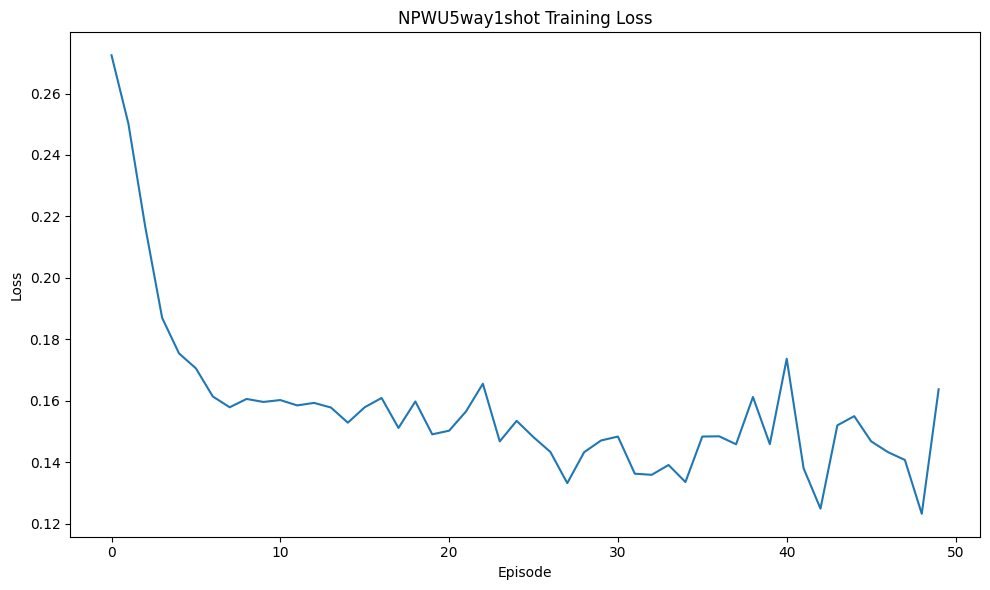

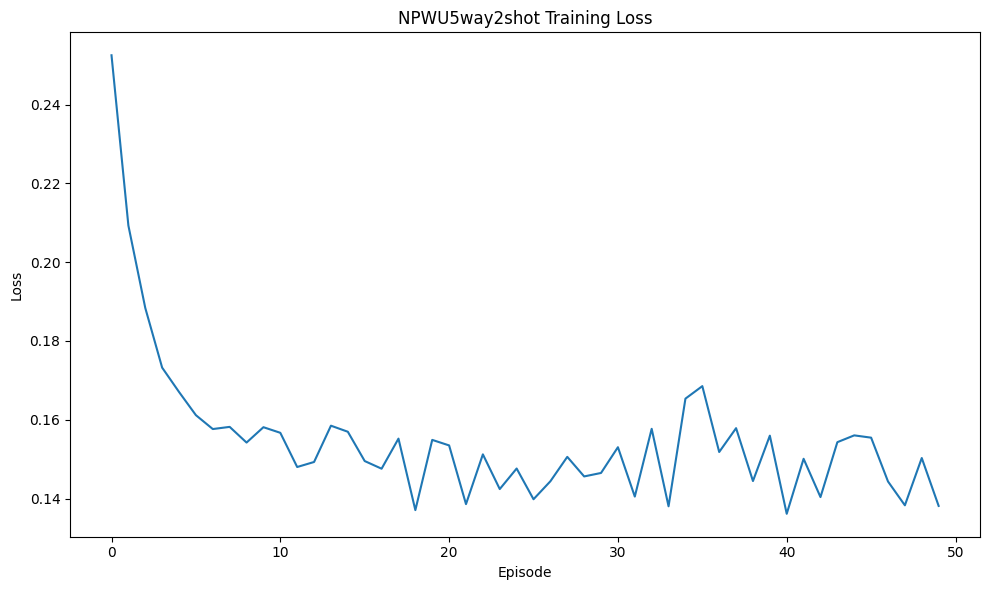

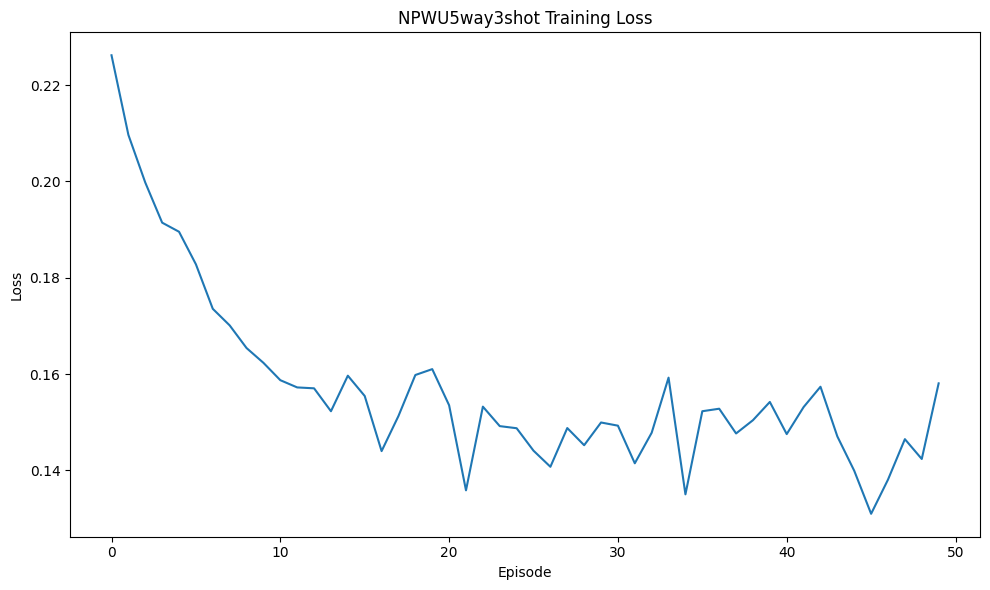

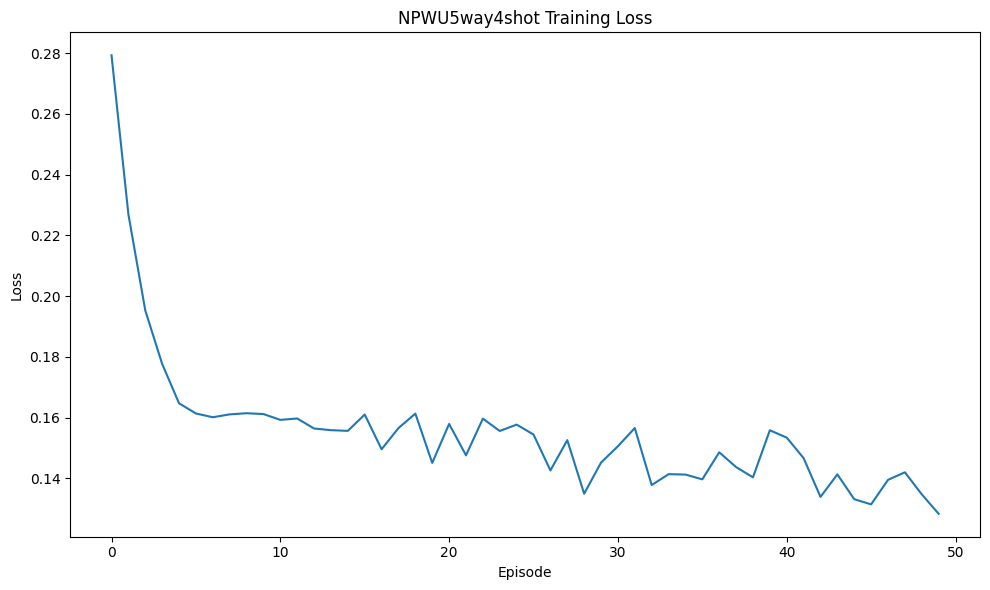

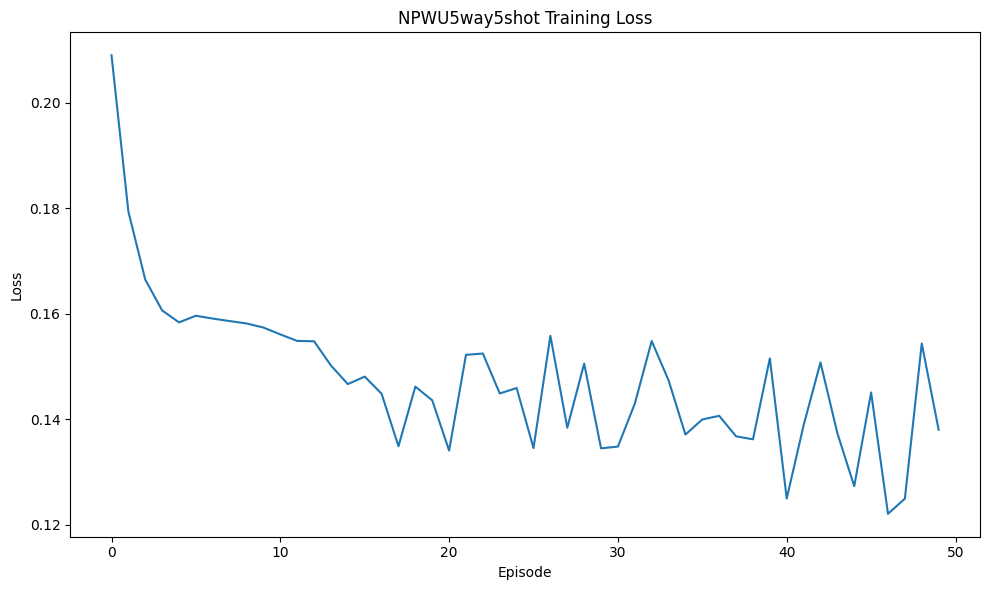

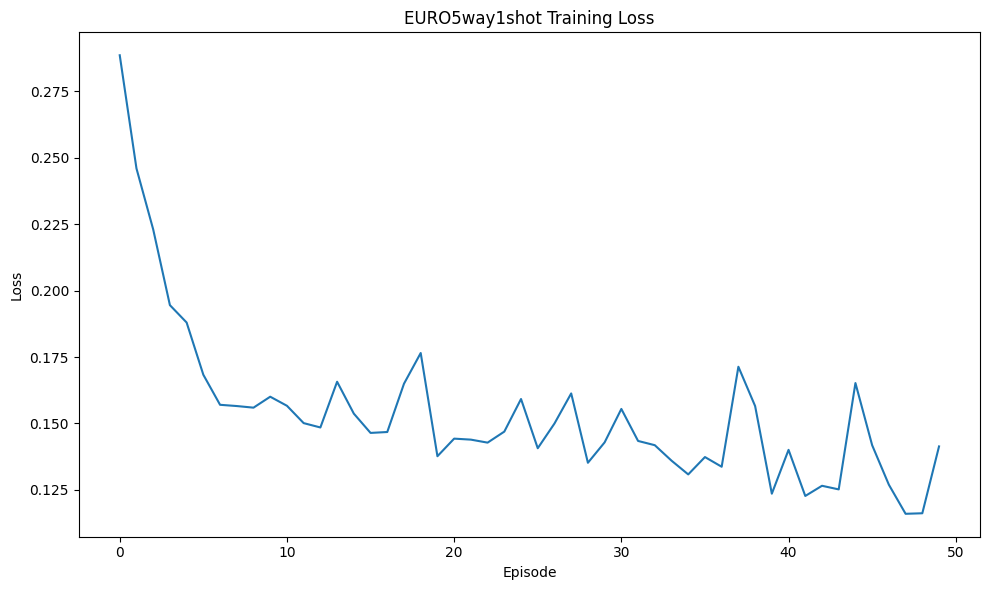

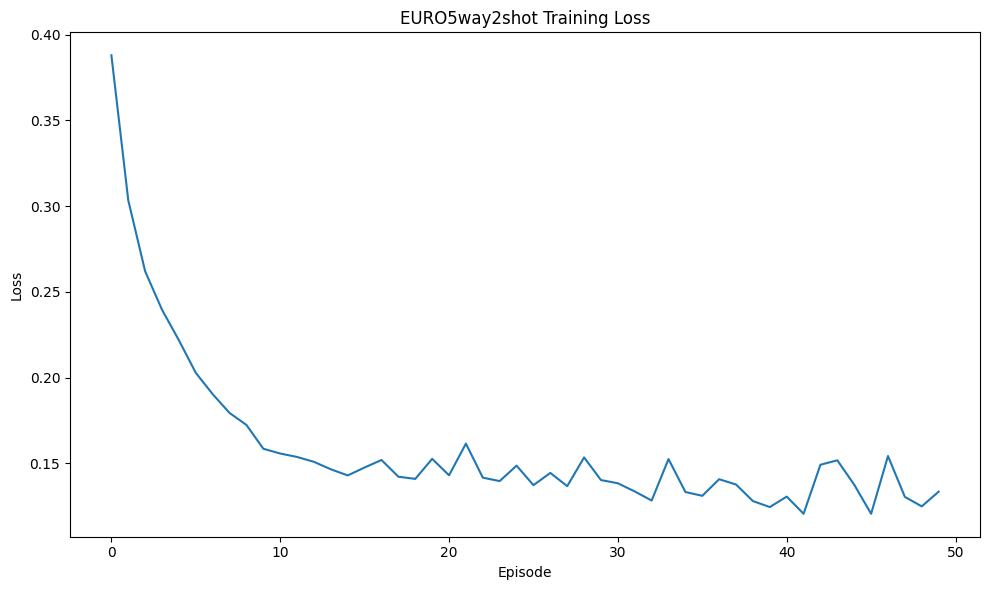

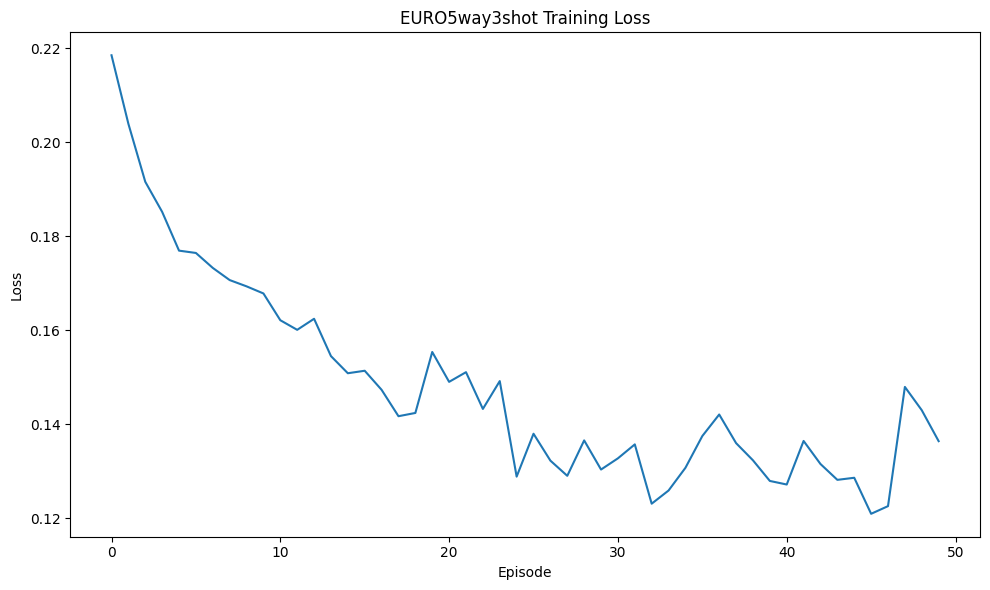

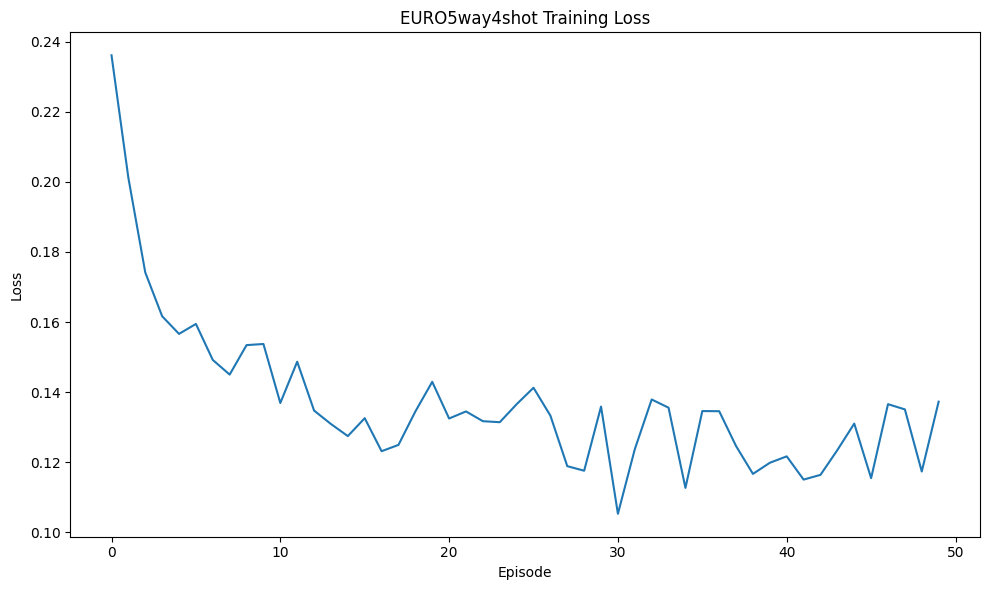

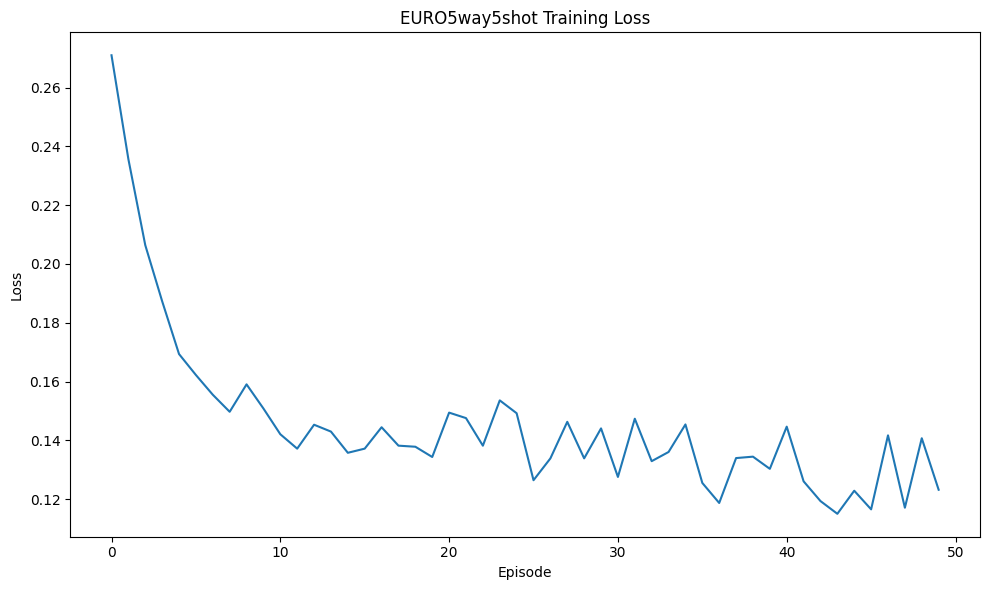

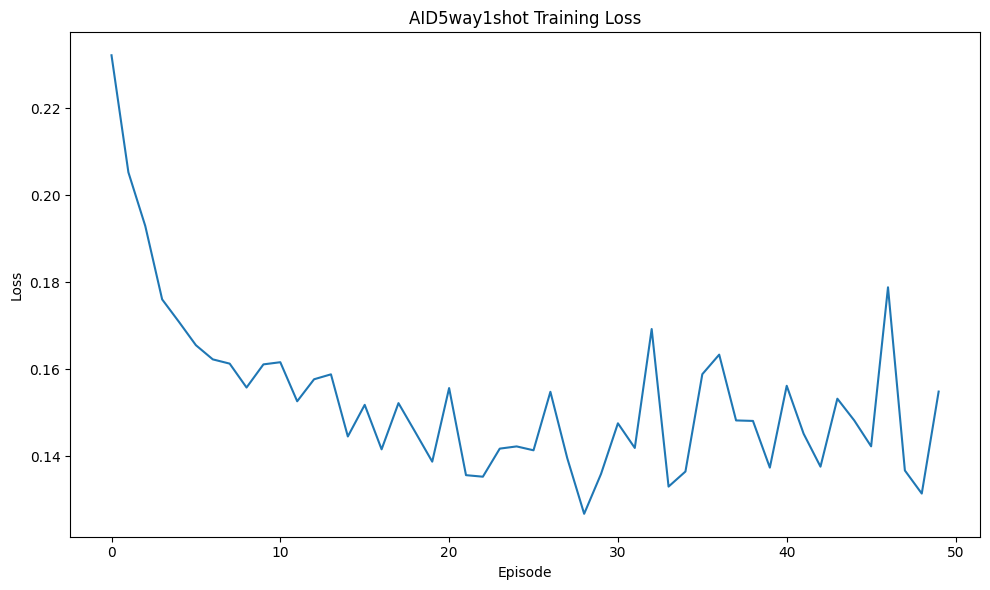

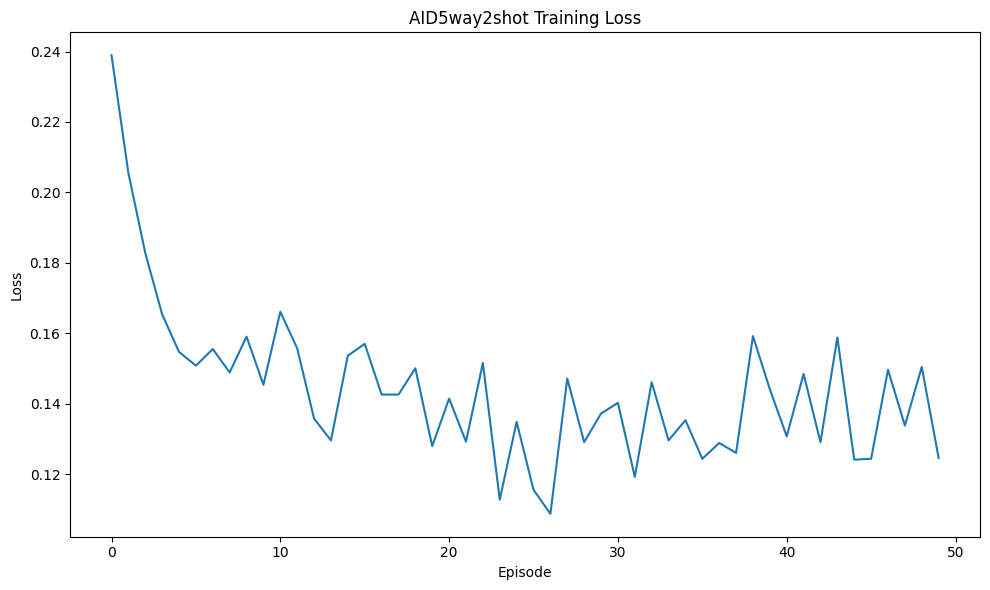

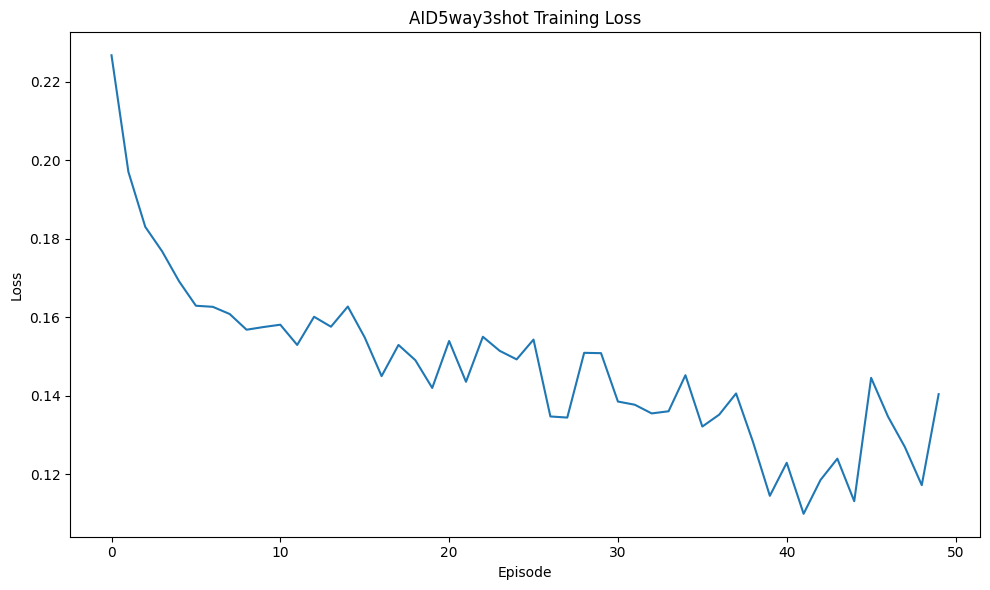

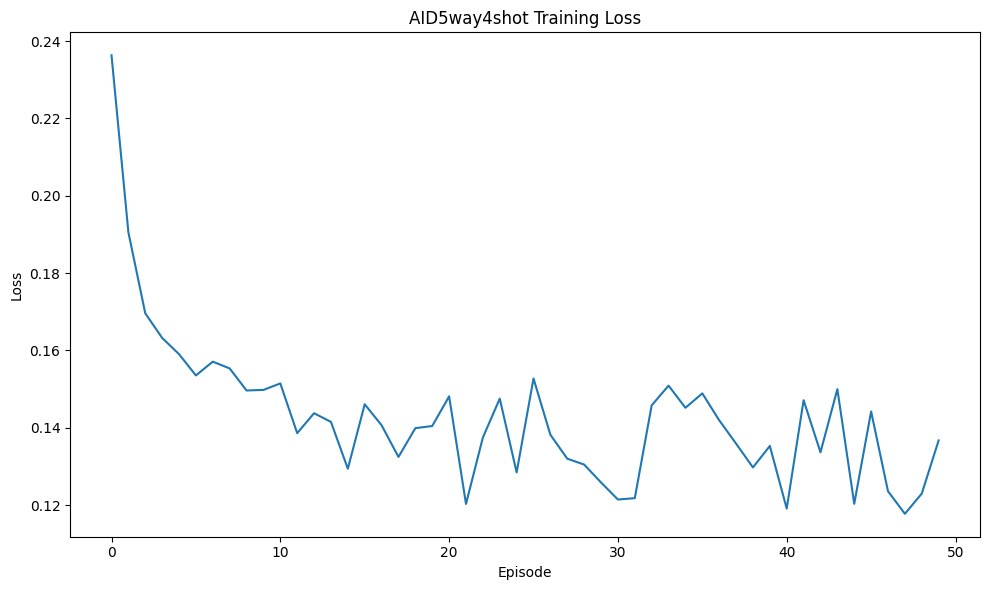

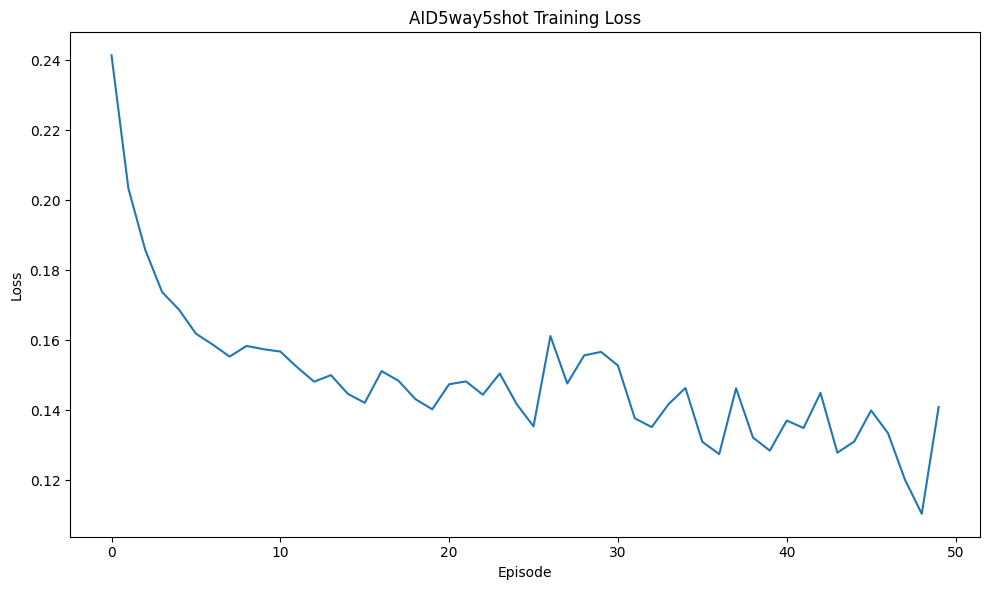

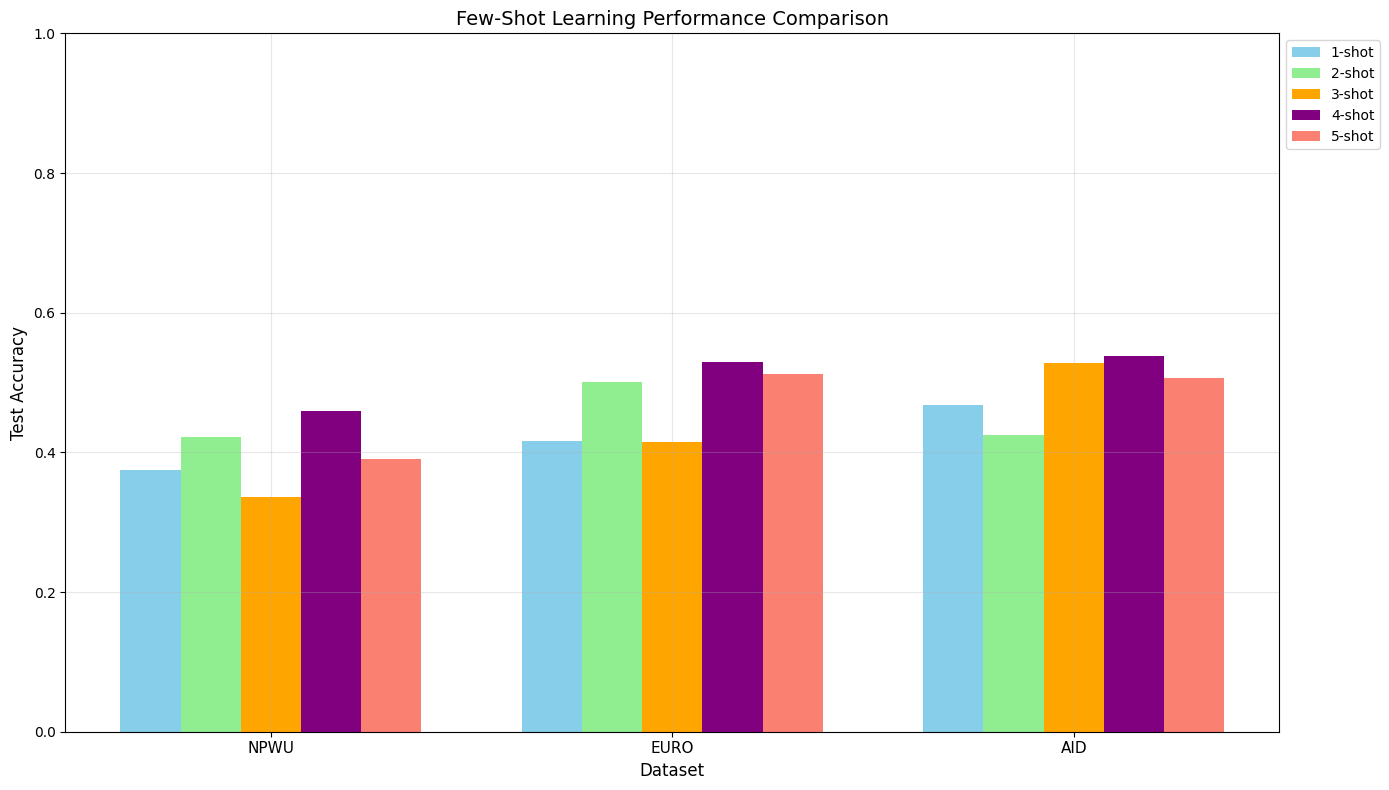

In [17]:
def main():
    """Main function to run optimized version"""
    # Extract datasets if needed
    extract_datasets()

    print("=" * 50)
    print("STARTING FAST RELATION NETWORK TRAINING")
    print("=" * 50)
    print(f"Device: {device}")
    print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"Episodes: {EPISODE}")
    print(f"Data subset: {DATA_SUBSET*100:.0f}%")
    print(f"Batch size: {BATCH_SIZE}")
    print("=" * 50)

    # Store results
    all_results = {
        '1_shot': {},
        '2_shot': {},  # Added 2-shot
        '3_shot': {},  # Added 3-shot
        '4_shot': {},  # Added 4-shot
        '5_shot': {}
    }

    # Process datasets
    datasets = ['NPWU', 'EURO', 'AID']

    for dataset_name in datasets:
        print(f"\n{'='*40}")
        print(f"PROCESSING {dataset_name} DATASET")
        print(f"{'='*40}")

        # Load and preprocess dataset
        try:
            train_loader, val_loader, test_loader, class_names = preprocess_dataset(dataset_name, DATA_PATH)
            if train_loader is None:
                print(f"Skipping {dataset_name} - preprocessing failed")
                continue
        except Exception as e:
            print(f"Error processing {dataset_name}: {e}")
            continue

        # Run 5-way 1-shot experiment
        print(f"\n{'-'*20}")
        print(f"5-WAY 1-SHOT ON {dataset_name}")
        print(f"{'-'*20}")
        try:
            test_acc_1shot = train_relation_network(
                dataset_name, train_loader, val_loader, test_loader, n_way=5, k_shot=1
            )
            all_results['1_shot'][dataset_name] = {'test_acc': test_acc_1shot}
        except Exception as e:
            print(f"Error during 1-shot training: {e}")
            all_results['1_shot'][dataset_name] = {'test_acc': 0.0}

        # Run 5-way 2-shot experiment (NEW)
        print(f"\n{'-'*20}")
        print(f"5-WAY 2-SHOT ON {dataset_name}")
        print(f"{'-'*20}")
        try:
            test_acc_2shot = train_relation_network(
                dataset_name, train_loader, val_loader, test_loader, n_way=5, k_shot=2
            )
            all_results['2_shot'][dataset_name] = {'test_acc': test_acc_2shot}
        except Exception as e:
            print(f"Error during 2-shot training: {e}")
            all_results['2_shot'][dataset_name] = {'test_acc': 0.0}

        # Run 5-way 3-shot experiment (NEW)
        print(f"\n{'-'*20}")
        print(f"5-WAY 3-SHOT ON {dataset_name}")
        print(f"{'-'*20}")
        try:
            test_acc_3shot = train_relation_network(
                dataset_name, train_loader, val_loader, test_loader, n_way=5, k_shot=3
            )
            all_results['3_shot'][dataset_name] = {'test_acc': test_acc_3shot}
        except Exception as e:
            print(f"Error during 3-shot training: {e}")
            all_results['3_shot'][dataset_name] = {'test_acc': 0.0}

        # Run 5-way 4-shot experiment (NEW)
        print(f"\n{'-'*20}")
        print(f"5-WAY 4-SHOT ON {dataset_name}")
        print(f"{'-'*20}")
        try:
            test_acc_4shot = train_relation_network(
                dataset_name, train_loader, val_loader, test_loader, n_way=5, k_shot=4
            )
            all_results['4_shot'][dataset_name] = {'test_acc': test_acc_4shot}
        except Exception as e:
            print(f"Error during 4-shot training: {e}")
            all_results['4_shot'][dataset_name] = {'test_acc': 0.0}

        # Run 5-way 5-shot experiment
        print(f"\n{'-'*20}")
        print(f"5-WAY 5-SHOT ON {dataset_name}")
        print(f"{'-'*20}")
        try:
            test_acc_5shot = train_relation_network(
                dataset_name, train_loader, val_loader, test_loader, n_way=5, k_shot=5
            )
            all_results['5_shot'][dataset_name] = {'test_acc': test_acc_5shot}
        except Exception as e:
            print(f"Error during 5-shot training: {e}")
            all_results['5_shot'][dataset_name] = {'test_acc': 0.0}

    # Create overall comparison
    try:
        create_comparison_plot_extended(
            all_results, datasets, os.path.join(RESULTS_DIR, "overall_comparison.png")
        )
    except Exception as e:
        print(f"Error creating comparison plot: {e}")

    # Save all results
    try:
        np.save(os.path.join(RESULTS_DIR, "all_results.npy"), all_results)
        print(f"All results saved to {os.path.join(RESULTS_DIR, 'all_results.npy')}")
    except Exception as e:
        print(f"Error saving results: {e}")

    print("\n" + "=" * 50)
    print("EXPERIMENT COMPLETED SUCCESSFULLY")
    print("=" * 50)
    print(f"Results directory: {RESULTS_DIR}")

    # Print final summary with all shot configurations
    print("\nFinal Results Summary:")
    print("-" * 70)
    print(f"{'Dataset':<10} {'1-Shot':<10} {'2-Shot':<10} {'3-Shot':<10} {'4-Shot':<10} {'5-Shot':<10}")
    print("-" * 70)

    for dataset in datasets:
        acc_1shot = all_results['1_shot'].get(dataset, {}).get('test_acc', 0)
        acc_2shot = all_results['2_shot'].get(dataset, {}).get('test_acc', 0)
        acc_3shot = all_results['3_shot'].get(dataset, {}).get('test_acc', 0)
        acc_4shot = all_results['4_shot'].get(dataset, {}).get('test_acc', 0)
        acc_5shot = all_results['5_shot'].get(dataset, {}).get('test_acc', 0)
        print(f"{dataset:<10} {acc_1shot:.4f}     {acc_2shot:.4f}     {acc_3shot:.4f}     {acc_4shot:.4f}     {acc_5shot:.4f}")

    print("-" * 70)
if __name__ == "__main__":
    main()